# Methods of Computing the Global Optimum of Non-Convex Objectives

Isaac Hawn

ToDo

-Propose general problem and talk about solution difficulty and how there isn't a great way to solve these problems.
-Go over Piyavskii's procedure (lots of pictures)
-Go over Cone Search procedure (unity demonstration). Possible have run rust code on certain objectives so you can just show the graphs in the presentation.
-Go over proofs of convergence.
-Go over basin hopping procedure with lots of pictures
-Propose a practical problem like a (Krislock's problem in class with many local minima). Use Cone Search and Basin Hopping on it.

## Uniform Grid Search

In [1]:
function AB(f, α_val, β_val, x1, x2, L, k, a, b)
    fx2 = f(x2)
    if fx2 < β_val[2]
        β_val = (x2, fx2)
    end
    α_cand = (f(x1) + fx2)/2 - L *(b - a)/(2*k)
    if α_cand < α_val[2]
        αx = (x1 + x2)/2 + (f(x1) - fx2)/(2*L)
        α_val = (αx, α_cand)
    end
    return α_val, β_val
end

function ugs(f, L, a, b, start, maxit)
    ℓ = b - a
    α_vals = [(Inf, -Inf)]
    β_vals = [(Inf, Inf)]
    for k = start:maxit
        α = (0, Inf)
        β = (a, f(a))
        last = a
        for i = 1.0:k
            current = a + ℓ*i/k  
            α, β = AB(f, α, β, last, current, L, k, a, b)
            last = current
        end
        current = b
        α, β = AB(f, α, β, last, current, L, maxit, a, b)
        
        if α[2] > α_vals[length(α_vals)][2]
            push!(α_vals, α)
        else
            push!(α_vals, α_vals[length(α_vals)])
        end
        
        if β[2] < β_vals[length(β_vals)][2]
            push!(β_vals, β)
        else
            push!(β_vals, β_vals[length(β_vals)])
        end
    end
    popfirst!(α_vals)
    popfirst!(β_vals)

    return α_vals, β_vals
end

ugs (generic function with 1 method)

In [2]:
using Plots

f(x) = x^2 + 5*sin(5x)
a, b = -2.0, 2.0
L = 28.774
start = 1
endd = 500

α_vals, β_vals = ugs(f, L, a, b, start, endd);

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\Isaac\.julia\packages\Plots\Di0Qb\src\args.jl:1598


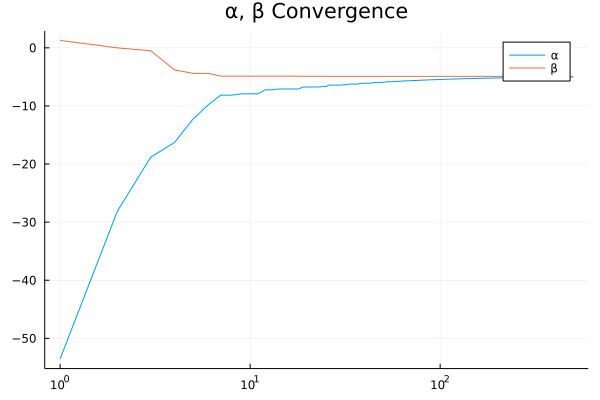

In [3]:
plot([α_vals[i][2] for i = 1:endd-start], label = "α", xscale=:log, title = "α, β Convergence")
plot!([β_vals[i][2] for i = 1:endd-start], label = "β")

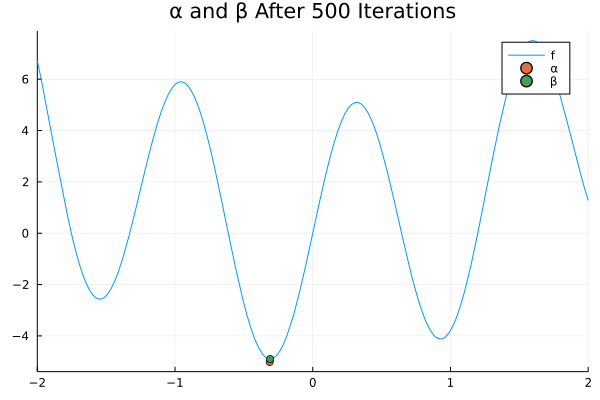

In [4]:
t = string("α and β After ", endd-start + 1, " Iterations")
plot(f, xlims = (a, b), label = "f", title = t)
scatter!([α_vals[length(α_vals)][1]], [α_vals[length(α_vals)][2]], label = "α")
scatter!([β_vals[length(β_vals)][1]], [β_vals[length(β_vals)][2]], label = "β")

┌ Info: Saved animation to 
│   fn = C:\Users\Isaac\Documents\Optimization\ThesisDefense\tmp.gif
└ @ Plots C:\Users\Isaac\.julia\packages\Plots\Di0Qb\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Isaac\\Documents\\Optimization\\ThesisDefense\\tmp.gif")
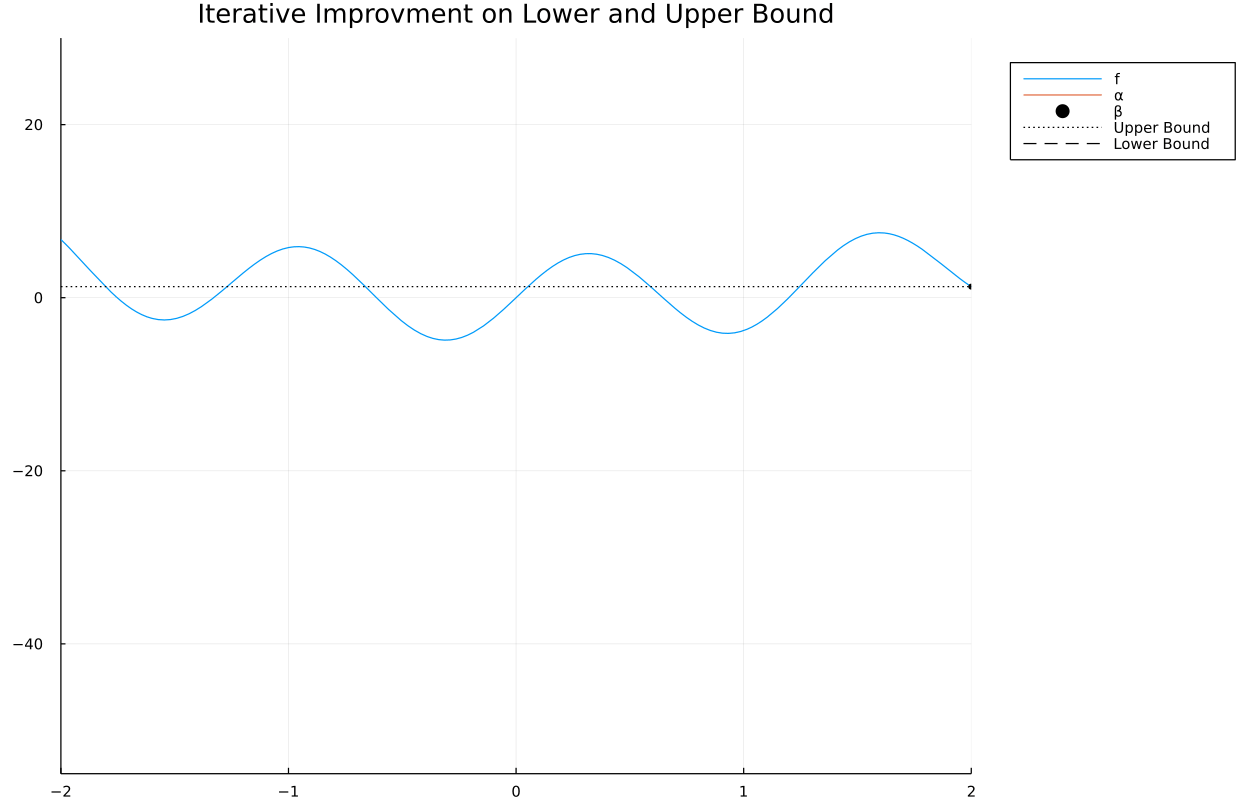

In [5]:
anim = @animate for i in 1:150
    α_vals, β_vals = ugs(f, L, a, b, 1, i);
    fα(x) = α_vals[i][2]
    fβ(x) = β_vals[i][2]
    plot(f, xlims = (a, b), ylims = (-55, 30), dpi = 125, label = "f", legend=:outertopright, size = (1000, 650))
    plot!([α_vals[i][1] for i = 1:length(α_vals)], [α_vals[i][2] for i = 1:length(α_vals)], label = "α", title = "Iterative Improvment on Lower and Upper Bound")
    scatter!([β_vals[i][1] for i = 1:length(β_vals)], [β_vals[i][2] for i = 1:length(β_vals)], label = "β", markersize = 3, color=:black)
    plot!(fβ, color=:black, style=:dot, label = "Upper Bound")
    plot!(fα, color=:black, style=:dash, label = "Lower Bound")
end
gif(anim, fps = 25)

## Piyavskii's Algorithm

In [6]:
SawTooth(x1, x2, z1, z2, L) = (z1 - z2)/2L + (x1 + x2)/2.0, (z1 + z2)/2 + L*(x1 - x2)/2

function Piyavskii(f, a, b, L, ϵ, m)
    fa = f(a); fb = f(b)
    x, y = SawTooth(a, b, fa, fb, L)

    x_list = [a, x, b]
    y_list = [fa, y, fb]
    X = [a, b]
    Y = [fa, fb]
    α_list = Float64[]
    β_list = Float64[]
    minpos = 0

    for i = 1:m
        minpos = argmin(y_list)
        y_list[minpos] = f(x_list[minpos])

        for j = 1:2
            pos1 = minpos - j%2
            pos2 = minpos + (j+1)%2
            x, y = SawTooth(x_list[pos1], x_list[pos2], y_list[pos1], y_list[pos2], L)
            append!(x_list, x); append!(y_list, y);
            append!(X, x)
            append!(Y, f(x))
        end

        p = sortperm(x_list); permute!(x_list, p); permute!(y_list, p)

        β = minimum(y_list)
        α, minpos = findmin(Y)
        append!(α_list, α); append!(β_list, β)

        if abs(α - β) <= ϵ
            break
        end
    end

    x = X[minpos]
    y = Y[minpos]

    return x, y, x_list, y_list, α_list, β_list
end

Piyavskii (generic function with 1 method)

In [7]:
function AnimPya(k, ps, ylim)
    anim = @animate for i in 1:k
        x, y, x_list, y_list, α_list, β_list = Piyavskii(f, a, b, L, ϵ, i)
        
        l = @layout [a b]
        p1 = plot(f, xlims = (a, b), ylims = ylim, dpi = 175, label = "f", legend = :outerbottom, size = (1000, 450), title = "Piyavskii's Algorithm")
        plot!(x_list, y_list, style=:dash, label = "Sawtooth Approximation")
        scatter!([x], [y], label = "Solution")
        
        p2 = plot([β_list[p] for p = 1:min(i, length(β_list))], label = "β", title = "α, β Convergence", color=:red, dpi = 150, legend=:outerbottom)
        plot!([α_list[p] for p = 1:min(i, length(α_list))], label = "α", color=:purple)
        
        plot(p1, p2, layout = l)
    end
    gif(anim, fps = ps)
end

AnimPya (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\Isaac\Documents\Optimization\ThesisDefense\tmp.gif
└ @ Plots C:\Users\Isaac\.julia\packages\Plots\Di0Qb\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Isaac\\Documents\\Optimization\\ThesisDefense\\tmp.gif")
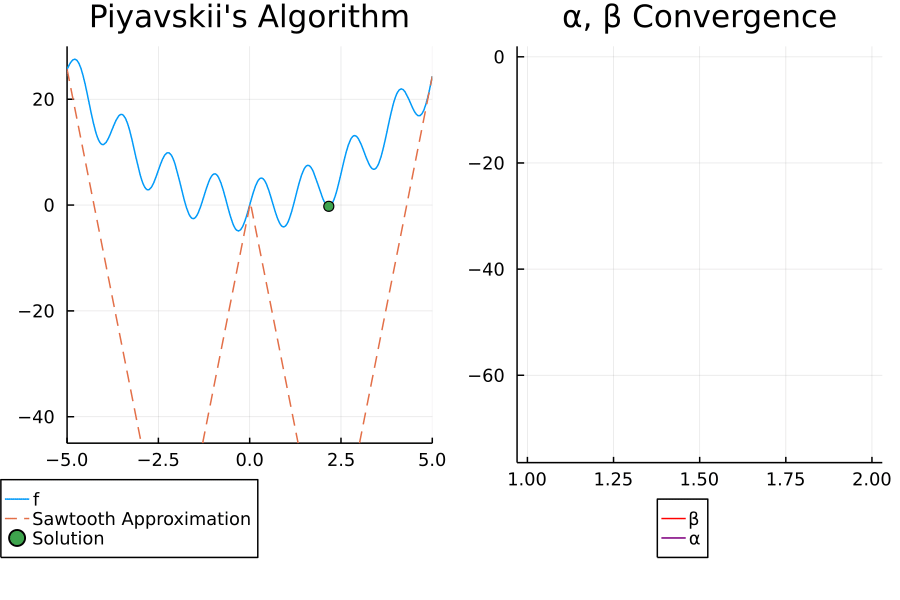

In [8]:
f(x) = x^2 + 5*sin(5x)
L = 34.79
a, b = -5.0, 5.0
ϵ = 1e-8
AnimPya(100, 20, (-45, 30))

┌ Info: Saved animation to 
│   fn = C:\Users\Isaac\Documents\Optimization\ThesisDefense\tmp.gif
└ @ Plots C:\Users\Isaac\.julia\packages\Plots\Di0Qb\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Isaac\\Documents\\Optimization\\ThesisDefense\\tmp.gif")
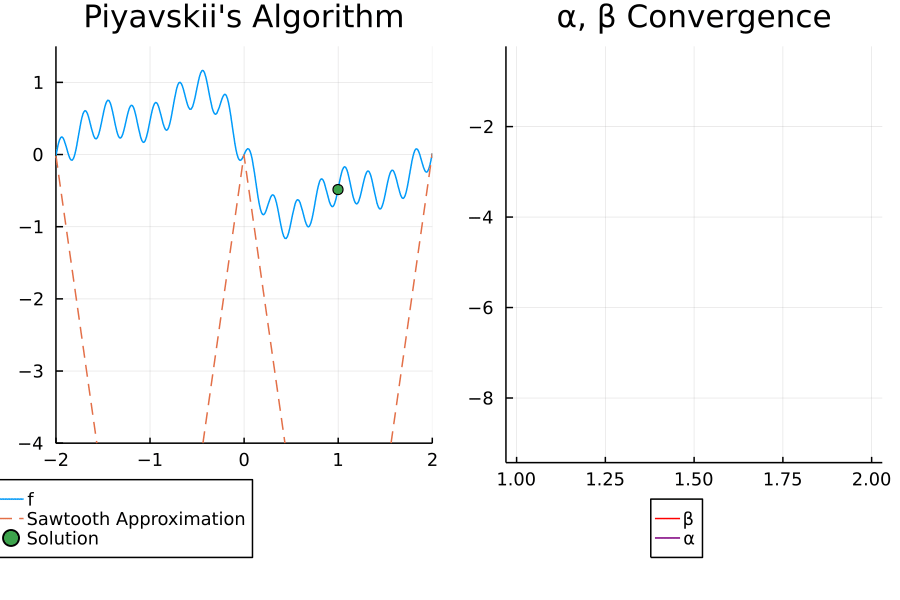

In [9]:
f(x) = -(x + sin(x))*exp(-x^2) + (sin(10*x))*(cos(15x)/2)
L = 9.165
a, b = -2.0, 2.0
ϵ = 1e-8
AnimPya(100, 20, (-4, 1.5))

┌ Info: Saved animation to 
│   fn = C:\Users\Isaac\Documents\Optimization\ThesisDefense\tmp.gif
└ @ Plots C:\Users\Isaac\.julia\packages\Plots\Di0Qb\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Isaac\\Documents\\Optimization\\ThesisDefense\\tmp.gif")
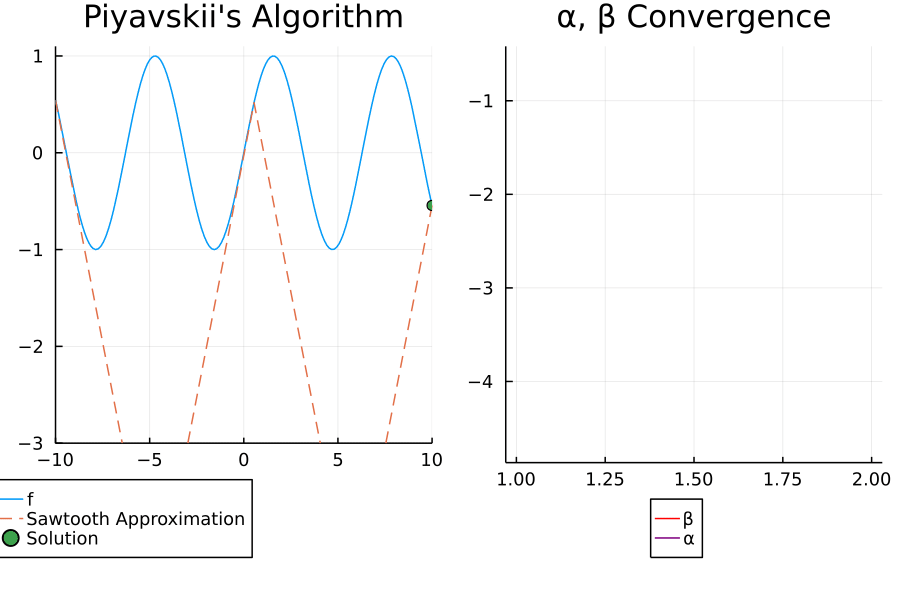

In [10]:
f(x) = sin(x)
L = 1.0
a, b = -10.0, 10.0
ϵ = 1e-8
AnimPya(200, 50, (-3, 1.1))

┌ Info: Saved animation to 
│   fn = C:\Users\Isaac\Documents\Optimization\ThesisDefense\tmp.gif
└ @ Plots C:\Users\Isaac\.julia\packages\Plots\Di0Qb\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Isaac\\Documents\\Optimization\\ThesisDefense\\tmp.gif")
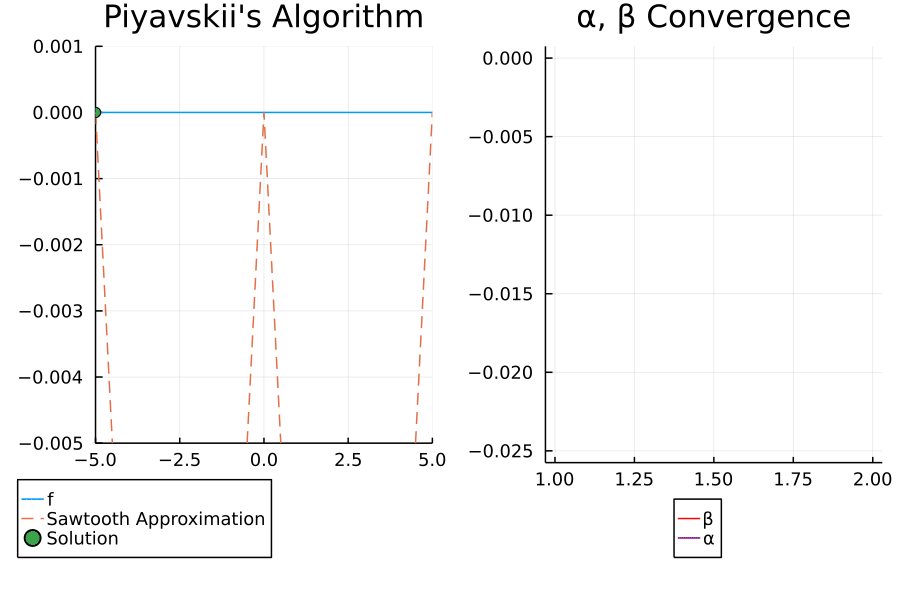

In [11]:
f(x) = 0
L = 0.01
a, b = -5.0, 5.0
ϵ = 1e-8
AnimPya(260, 30, (-0.005, 0.001))